## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from joblib import Parallel, delayed
import joblib
import os
import warnings
from math import pi
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("smoke_detection_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature[C]     62630 non-null  float64
 1   Humidity[%]        62630 non-null  float64
 2   TVOC[ppb]          62630 non-null  float64
 3   eCO2[ppm]          62630 non-null  float64
 4   Raw H2             62630 non-null  float64
 5   Raw Ethanol        62630 non-null  float64
 6   Pressure[hPa]      62630 non-null  float64
 7   PM1.0              62630 non-null  float64
 8   NC0.5              62630 non-null  float64
 9   Fire Alarm         62630 non-null  int64  
 10  Temp_Category      50605 non-null  object 
 11  Humidity_Category  62630 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 5.7+ MB


In [3]:
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,NC0.5,Fire Alarm,Temp_Category,Humidity_Category
0,0.280622,0.994947,-0.248614,-0.141679,-2.335935,-2.025006,0.831761,-0.109043,-0.115215,0,Moderate,High
1,0.281666,0.917115,-0.248614,-0.141679,-2.192796,-1.810079,0.838521,-0.109043,-0.115215,0,Moderate,High
2,0.282641,0.837028,-0.248614,-0.141679,-2.086359,-1.624683,0.834014,-0.109043,-0.115215,0,Moderate,High
3,0.283686,0.760324,-0.248614,-0.141679,-2.027636,-1.485227,0.832512,-0.109043,-0.115215,0,Moderate,High
4,0.284730,0.693773,-0.248614,-0.141679,-1.979923,-1.367099,0.838521,-0.109043,-0.115215,0,Moderate,High


In [4]:
df = df.drop(axis=1, columns=['Temp_Category', 'Humidity_Category'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  float64
 3   eCO2[ppm]       62630 non-null  float64
 4   Raw H2          62630 non-null  float64
 5   Raw Ethanol     62630 non-null  float64
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   NC0.5           62630 non-null  float64
 9   Fire Alarm      62630 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 4.8 MB


# Search Algorithm

In [5]:
X = df.drop('Fire Alarm', axis=1)
y = df['Fire Alarm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200, 500],
            "model__max_depth": [None, 5, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [3, 5, 10],
            "model__subsample": [0.8, 0.9, 1.0]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.01, 0.1, 0.5, 1.0],
            "model__algorithm": ['SAMME', 'SAMME.R']
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": list(range(3, 16)),
            "model__weights": ["uniform", "distance"],
            "model__metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=2000),
        "params": {
            "model__C": [0.01, 0.1, 1, 10, 100],
            "model__penalty": ["l1", "l2", "elasticnet"],
            "model__solver": ["saga"],
            "model__l1_ratio": [0.1, 0.5, 0.7, 0.9]
        }
    },
    "SVM": {
        "model": SVC(random_state=42, probability=True),
        "params": {
            "model__C": [0.1, 1, 10, 100],
            "model__kernel": ["linear", "rbf", "poly"],
            "model__gamma": ["scale", "auto", 0.001, 0.01]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__max_depth": [None, 3, 5, 10, 15, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__criterion": ["gini", "entropy"]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {
            "model__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    }
}

print("Available models:")
for i, (name, config) in enumerate(models.items(), 1):
    print(f"{i}. {name}")
    print(f"   Key parameters: {list(config['params'].keys())}")
    print()

Available models:
1. Random Forest
   Key parameters: ['model__n_estimators', 'model__max_depth', 'model__min_samples_split', 'model__min_samples_leaf']

2. Gradient Boosting
   Key parameters: ['model__n_estimators', 'model__learning_rate', 'model__max_depth', 'model__subsample']

3. AdaBoost
   Key parameters: ['model__n_estimators', 'model__learning_rate', 'model__algorithm']

4. KNN
   Key parameters: ['model__n_neighbors', 'model__weights', 'model__metric']

5. Logistic Regression
   Key parameters: ['model__C', 'model__penalty', 'model__solver', 'model__l1_ratio']

6. SVM
   Key parameters: ['model__C', 'model__kernel', 'model__gamma']

7. Decision Tree
   Key parameters: ['model__max_depth', 'model__min_samples_split', 'model__min_samples_leaf', 'model__criterion']

8. Naive Bayes
   Key parameters: ['model__var_smoothing']



In [7]:
def save_classification_report(y_true, y_pred, model_name, save_path="reports"):
    """Generate and save classification report as a text file."""
    os.makedirs(save_path, exist_ok=True)
    report = classification_report(y_true, y_pred)
    file_path = f"{save_path}/{model_name.replace(' ', '_')}_classification_report.txt"
    with open(file_path, "w") as f:
        f.write(f"===== Classification Report: {model_name} =====\n\n")
        f.write(report)
    print(f"📄 Classification report saved to {file_path}")


def save_confusion_matrix(y_true, y_pred, model_name, save_path="reports"):
    """Generate and save confusion matrix as PNG."""
    os.makedirs(save_path, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    file_path = f"{save_path}/{model_name.replace(' ', '_')}_confusion_matrix.png"
    plt.savefig(file_path)
    plt.close()
    print(f"🖼️ Confusion matrix saved to {file_path}")

In [ ]:
def tune_model(name, model_config, X_train, y_train, X_test, y_test, save_path="models"):
    """Function to run RandomizedSearchCV for a given model with scaling when needed."""
    
    # Models that need scaling
    scaling_models = ["KNN", "Logistic Regression", "SVM", "Naive Bayes"]
    
    if name in scaling_models:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model_config["model"])
        ])
        # Update param names for pipeline
        params = {}
        for key, value in model_config["params"].items():
            params[key] = value
    else:
        pipe = Pipeline([
            ("model", model_config["model"])
        ])
        params = model_config["params"]

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        n_iter=15,
        scoring="f1_weighted",
        n_jobs=-1,
        cv=5,
        random_state=42
    )

    print(f"Tuning {name}...")
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Save best model
    os.makedirs(save_path, exist_ok=True)
    model_file = f"{save_path}/{name.replace(' ', '_')}_best.pkl"
    joblib.dump(best_model, model_file)

    # Evaluate
    y_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average="weighted")
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate AUC if possible
    try:
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)
            if y_proba.shape[1] == 2:  # Binary classification
                test_auc = roc_auc_score(y_test, y_proba[:, 1])
            else:  # Multi-class
                test_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        else:
            test_auc = None
    except:
        test_auc = None

    # Save reports
    save_classification_report(y_test, y_pred, name)
    save_confusion_matrix(y_test, y_pred, name)

    print(f"{name} completed - CV: {search.best_score_:.4f}, Test F1: {test_f1:.4f}")

    return {
        "Model": name,
        "Best Params": search.best_params_,
        "Best CV Score": search.best_score_,
        "Test F1 Score": test_f1,
        "Test Accuracy": test_accuracy,
        "Test AUC": test_auc,
        "Model File": model_file,
        "Best Estimator": best_model
    }


# ========== Run All Models in Parallel ==========

results = Parallel(n_jobs=-1, verbose=1)(
    delayed(tune_model)(name, config, X_train, y_train, X_test, y_test)
    for name, config in models.items()
)

# Summary dataframe
results_df = pd.DataFrame(results).sort_values(by="Test F1 Score", ascending=False)
results_df_display = results_df.drop(['Best Estimator'], axis=1)  # Remove estimator for display
results_df_display.to_csv("search_summary.csv", index=False)

print("✅ Done! Summary saved to search_summary.csv, models in /models, reports in /reports.")
print(results_df)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.8min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.8min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 64.7min finished
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 64.7min finished


✅ Done! Summary saved to search_summary.csv, models in /models, reports in /reports.
                 Model                                        Best Params  \
1    Gradient Boosting  {'model__subsample': 1.0, 'model__n_estimators...   
6        Decision Tree  {'model__min_samples_split': 2, 'model__min_sa...   
0        Random Forest  {'model__n_estimators': 500, 'model__min_sampl...   
5                  SVM  {'model__kernel': 'rbf', 'model__gamma': 'auto...   
2             AdaBoost  {'model__n_estimators': 200, 'model__learning_...   
3                  KNN  {'model__weights': 'uniform', 'model__n_neighb...   
4  Logistic Regression  {'model__solver': 'saga', 'model__penalty': 'l...   
7          Naive Bayes                    {'model__var_smoothing': 1e-09}   

   Best CV Score  Test F1 Score  Test Accuracy  Test AUC  \
1       0.999760       1.000000       1.000000  1.000000   
6       0.999741       1.000000       1.000000  1.000000   
0       0.999741       0.999840       0.9

# Results

In [9]:
results_df = pd.read_csv("search_summary.csv")
results_df

,Model,Best Params,Best CV Score,Test F1 Score,Test Accuracy,Test AUC,Model File
0,Gradient Boosting,"{'model__subsample': 1.0, 'model__n_estimators...",0.999760,1.000000,1.000000,1.000000,models/Gradient_Boosting_best.pkl
1,Decision Tree,"{'model__min_samples_split': 2, 'model__min_sa...",0.999741,1.000000,1.000000,1.000000,models/Decision_Tree_best.pkl
2,Random Forest,"{'model__n_estimators': 500, 'model__min_sampl...",0.999741,0.999840,0.999840,1.000000,models/Random_Forest_best.pkl
3,SVM,"{'model__kernel': 'rbf', 'model__gamma': 'auto...",0.999641,0.999601,0.999601,0.999968,models/SVM_best.pkl
4,AdaBoost,"{'model__n_estimators': 200, 'model__learning_...",0.999501,0.999441,0.999441,0.999998,models/AdaBoost_best.pkl
5,KNN,"{'model__weights': 'uniform', 'model__n_neighb...",0.999201,0.999281,0.999281,0.999719,models/KNN_best.pkl
6,Logistic Regression,"{'model__solver': 'saga', 'model__penalty': 'l...",0.894283,0.893136,0.895018,0.963597,models/Logistic_Regression_best.pkl
7,Naive Bayes,{'model__var_smoothing': 1e-09},0.727846,0.734774,0.776465,0.936095,models/Naive_Bayes_best.pkl


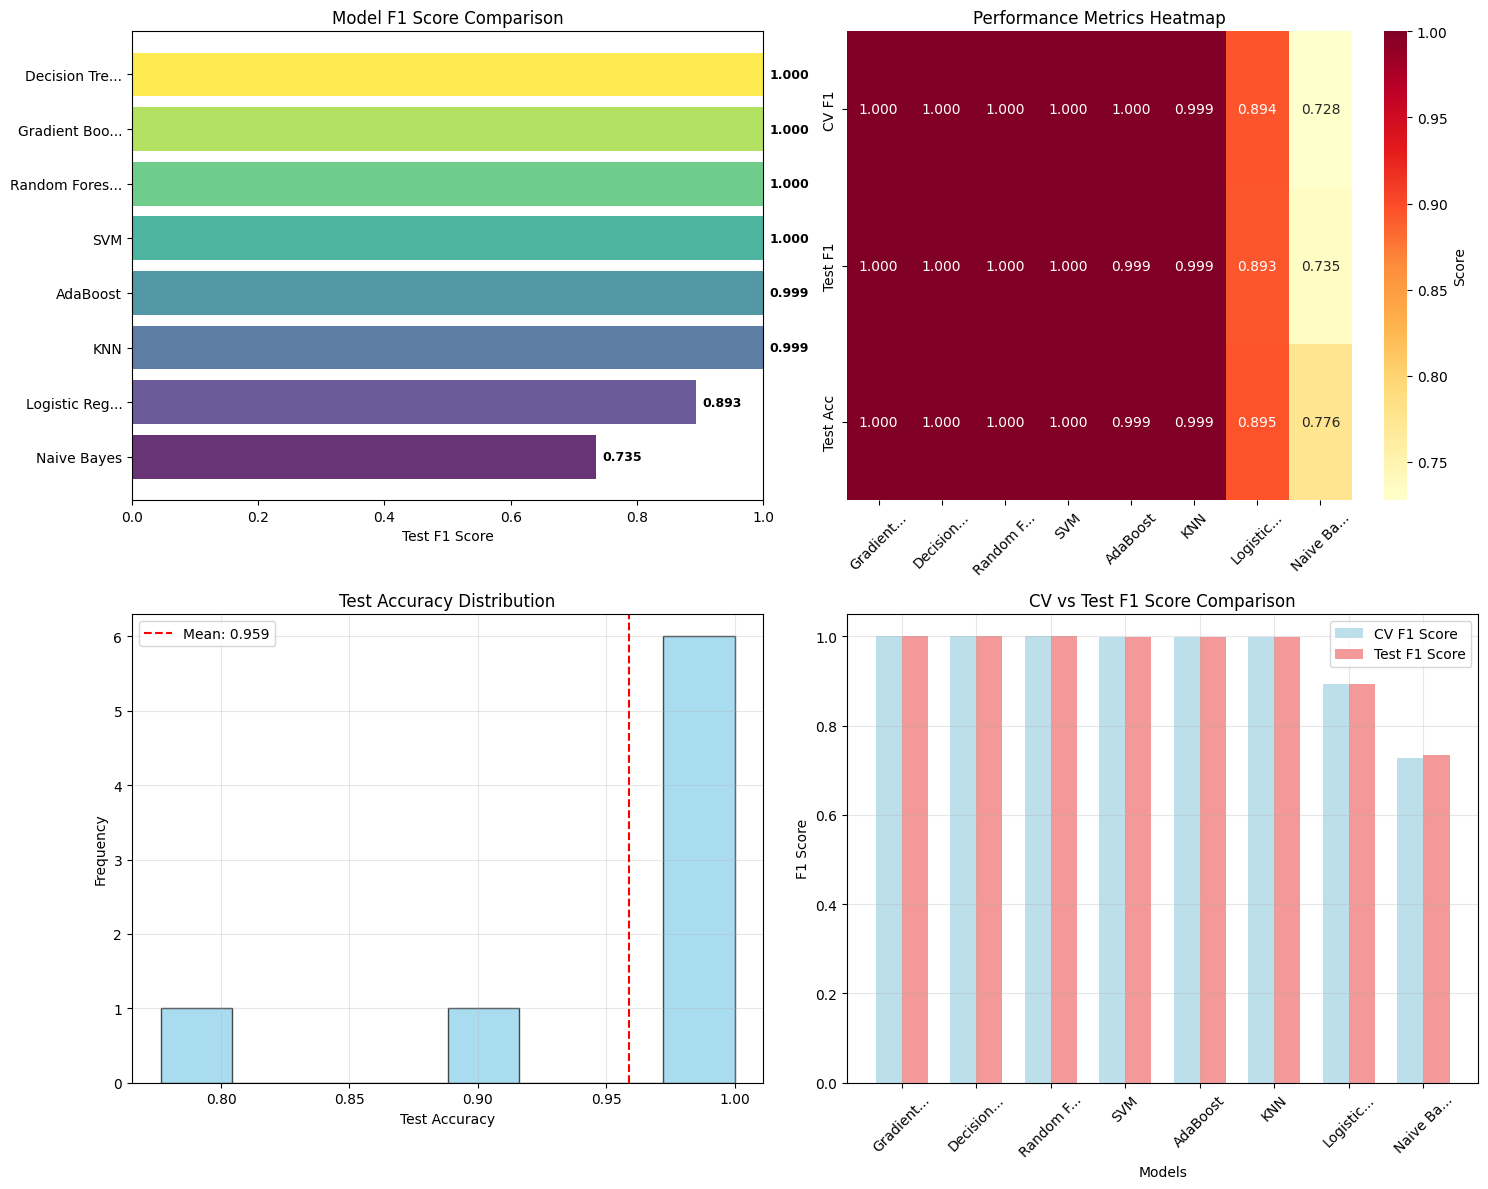

In [12]:
plt.figure(figsize=(15, 12))

# 1. F1 Score and Accuracy Comparison
plt.subplot(2, 2, 1)
models_sorted = results_df_display.sort_values('Test F1 Score', ascending=True)
y_pos = np.arange(len(models_sorted))
colors = plt.cm.viridis(np.linspace(0, 1, len(models_sorted)))

bars = plt.barh(y_pos, models_sorted['Test F1 Score'], color=colors, alpha=0.8)
plt.yticks(y_pos, [model[:12] + '...' if len(model) > 12 else model for model in models_sorted['Model']])
plt.xlabel('Test F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0, 1)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, models_sorted['Test F1 Score'])):
    plt.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold', fontsize=9)

# 2. Performance Metrics Heatmap
plt.subplot(2, 2, 2)
# Create heatmap data
heatmap_data = results_df_display[['Best CV Score', 'Test F1 Score', 'Test Accuracy']].T
sns.heatmap(heatmap_data, 
            xticklabels=[model[:8] + '...' if len(model) > 8 else model for model in results_df_display['Model']], 
            yticklabels=['CV F1', 'Test F1', 'Test Acc'],
            annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Score'})
plt.title('Performance Metrics Heatmap')
plt.xticks(rotation=45)

# 3. Model Accuracy Distribution
plt.subplot(2, 2, 3)
plt.hist(results_df_display['Test Accuracy'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(results_df_display['Test Accuracy'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df_display["Test Accuracy"].mean():.3f}')
plt.xlabel('Test Accuracy')
plt.ylabel('Frequency')
plt.title('Test Accuracy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Model Comparison Bar Chart
plt.subplot(2, 2, 4)
x_pos = np.arange(len(results_df_display))
width = 0.35

plt.bar(x_pos - width/2, results_df_display['Best CV Score'], width, 
        label='CV F1 Score', alpha=0.8, color='lightblue')
plt.bar(x_pos + width/2, results_df_display['Test F1 Score'], width, 
        label='Test F1 Score', alpha=0.8, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('CV vs Test F1 Score Comparison')
plt.xticks(x_pos, [model[:8] + '...' if len(model) > 8 else model for model in results_df_display['Model']], rotation=45)
plt.legend()
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix Grid for All Models

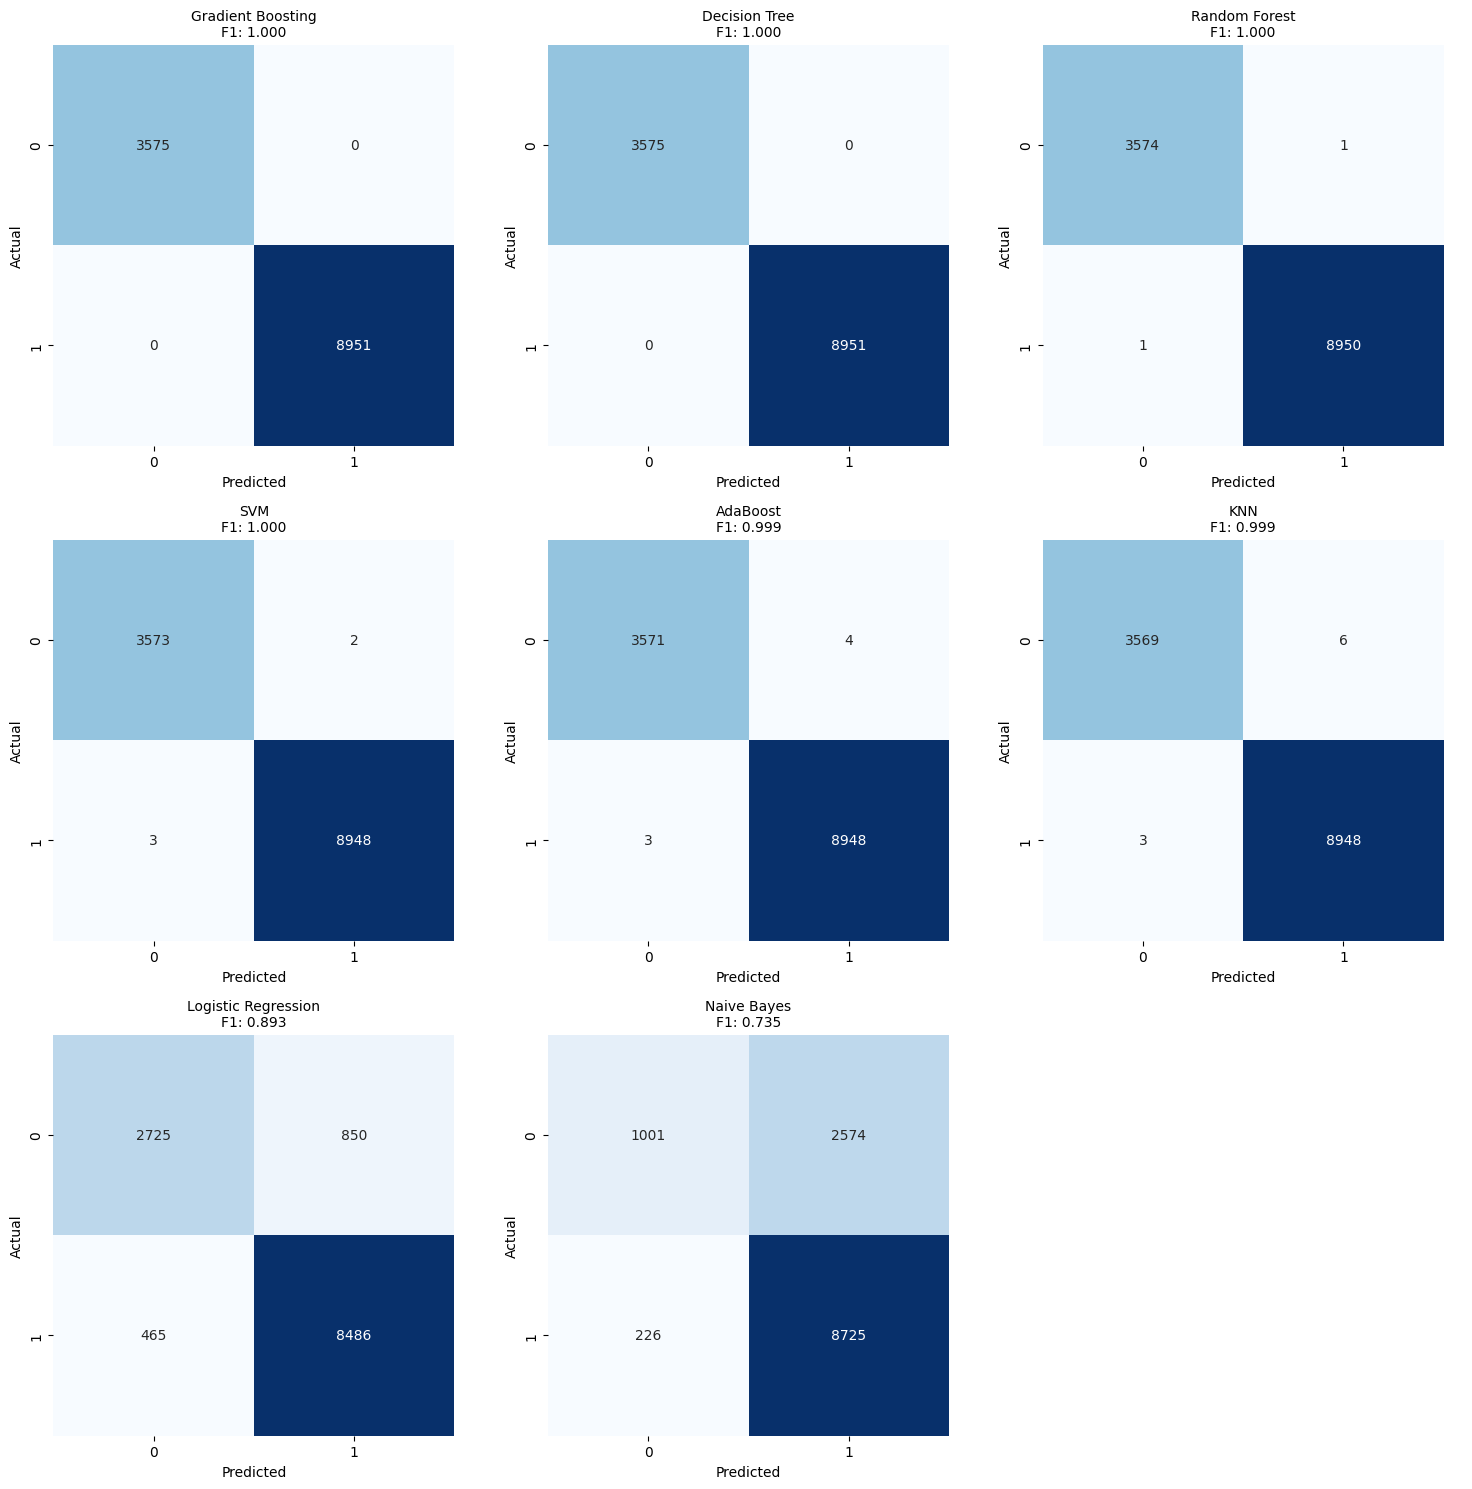

In [ ]:
n_models = len(results_df)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (_, row) in enumerate(results_df.iterrows()):
    model_name = row['Model']
    model_file = row['Model File']
    best_model = joblib.load(model_file)
    
    # Get predictions
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, square=True)
    axes[idx].set_title(f'{model_name}\nF1: {row["Test F1 Score"]:.3f}', fontsize=10)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## ROC Curves for Models

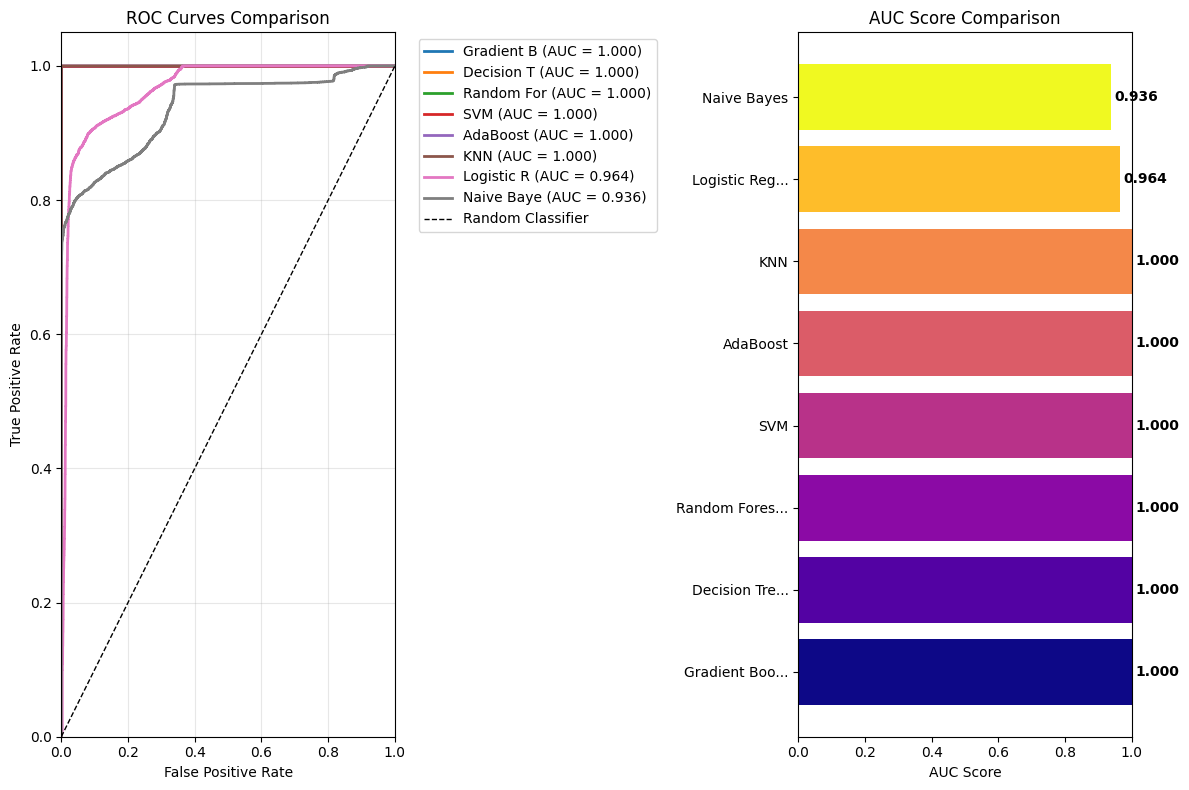

In [18]:
plt.figure(figsize=(12, 8))

# Check if it's binary classification
unique_classes = np.unique(y_test)
is_binary = len(unique_classes) == 2

if is_binary:
    plt.subplot(1, 2, 1)
    
    for _, row in results_df.iterrows():
        model_name = row['Model']
        model_file = row['Model File']
        best_model = joblib.load(model_file)
        
        try:
            if hasattr(best_model, 'predict_proba'):
                y_proba = best_model.predict_proba(X_test)[:, 1]
            elif hasattr(best_model, 'decision_function'):
                y_proba = best_model.decision_function(X_test)
            else:
                continue
                
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, linewidth=2, label=f'{model_name[:10]} (AUC = {roc_auc:.3f})')
        except:
            continue
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # AUC Score comparison
    plt.subplot(1, 2, 2)
    auc_scores = []
    model_names = []
    
    for _, row in results_df.iterrows():
        if row['Test AUC'] is not None:
            auc_scores.append(row['Test AUC'])
            model_names.append(row['Model'])
    
    if auc_scores:
        colors = plt.cm.plasma(np.linspace(0, 1, len(auc_scores)))
        bars = plt.barh(range(len(auc_scores)), auc_scores, color=colors)
        plt.yticks(range(len(auc_scores)), [name[:12] + '...' if len(name) > 12 else name for name in model_names])
        plt.xlabel('AUC Score')
        plt.title('AUC Score Comparison')
        plt.xlim(0, 1)
        
        # Add value labels
        for i, (bar, score) in enumerate(zip(bars, auc_scores)):
            plt.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'ROC Curves are only applicable for binary classification.\nThis appears to be a multi-class problem.', 
             ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)
    plt.title('ROC Analysis')

plt.tight_layout()
plt.show()

## Cross-Validation

In [22]:
cv_detailed_results = {}
cv_scores_all = {}

for name, config in models.items():
    print(f"Analyzing {name}...")
    
    # Use scaling for appropriate models
    scaling_models = ["KNN", "Logistic Regression", "SVM", "Naive Bayes"]
    
    if name in scaling_models:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", config["model"])
        ])
    else:
        pipe = Pipeline([
            ("model", config["model"])
        ])
    
    # Load the best model from saved file
    model_file = results_df[results_df['Model'] == name]['Model File'].iloc[0]
    best_model = joblib.load(model_file)
    
    # Cross-validation with multiple metrics
    cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    
    cv_detailed_results[name] = {
        'F1_mean': cv_f1.mean(),
        'F1_std': cv_f1.std(),
        'Accuracy_mean': cv_accuracy.mean(),
        'Accuracy_std': cv_accuracy.std(),
        'F1_scores': cv_f1,
        'Accuracy_scores': cv_accuracy
    }

# Create CV results dataframe
cv_df = pd.DataFrame({
    'Model': list(cv_detailed_results.keys()),
    'CV_F1_Mean': [cv_detailed_results[model]['F1_mean'] for model in cv_detailed_results.keys()],
    'CV_F1_Std': [cv_detailed_results[model]['F1_std'] for model in cv_detailed_results.keys()],
    'CV_Acc_Mean': [cv_detailed_results[model]['Accuracy_mean'] for model in cv_detailed_results.keys()],
    'CV_Acc_Std': [cv_detailed_results[model]['Accuracy_std'] for model in cv_detailed_results.keys()]
})

print("\n Cross-Validation Results:")
print(cv_df.round(4))

Analyzing Random Forest...
Analyzing Gradient Boosting...
Analyzing AdaBoost...
Analyzing KNN...
Analyzing Logistic Regression...
Analyzing SVM...
Analyzing Decision Tree...
Analyzing Naive Bayes...

 Cross-Validation Results:
                 Model  CV_F1_Mean  CV_F1_Std  CV_Acc_Mean  CV_Acc_Std
0        Random Forest      0.9997     0.0002       0.9997      0.0002
1    Gradient Boosting      0.9998     0.0002       0.9998      0.0002
2             AdaBoost      0.9995     0.0002       0.9995      0.0002
3                  KNN      0.9992     0.0005       0.9992      0.0005
4  Logistic Regression      0.8943     0.0045       0.8963      0.0045
5                  SVM      0.9996     0.0003       0.9996      0.0003
6        Decision Tree      0.9997     0.0002       0.9997      0.0002
7          Naive Bayes      0.7278     0.0028       0.7724      0.0021


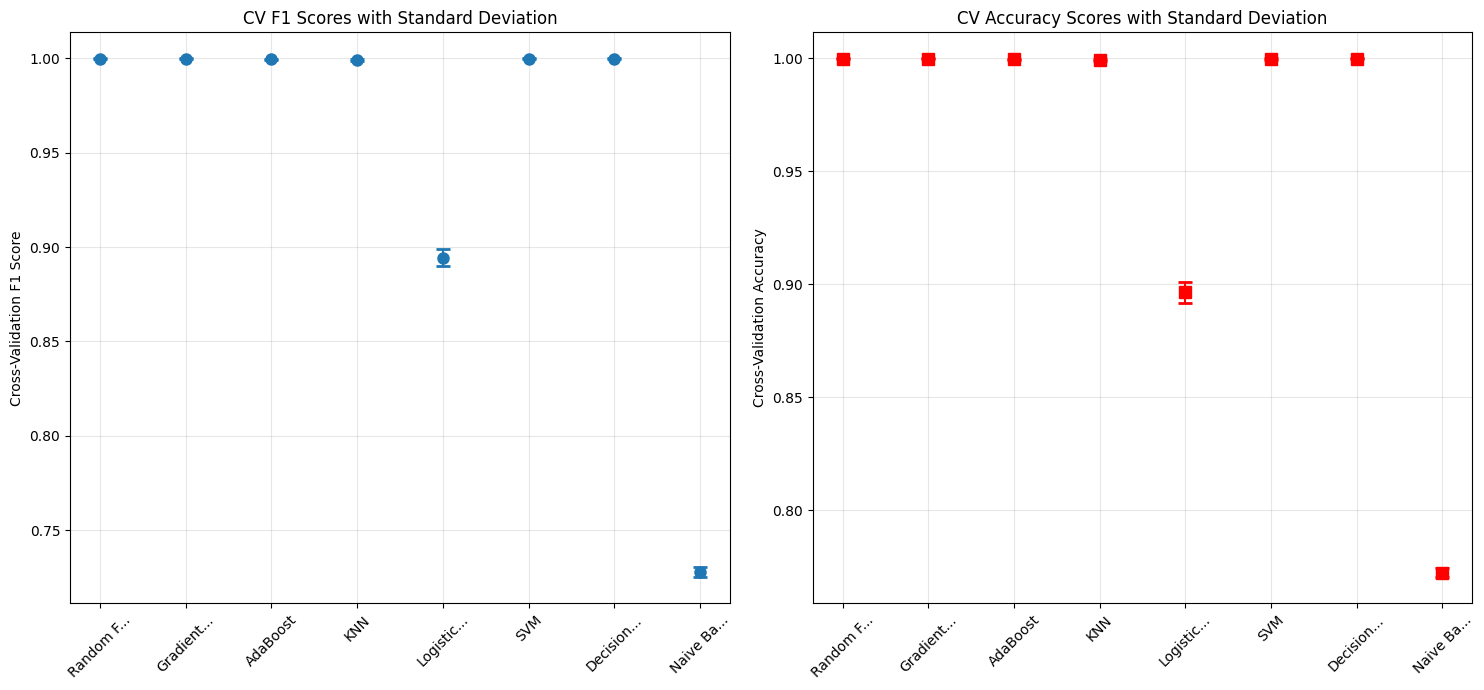

In [34]:
plt.figure(figsize=(15, 7))

# 1. CV F1 Scores with Error Bars
plt.subplot(1, 2, 1)
models_list = list(cv_detailed_results.keys())
f1_means = [cv_detailed_results[model]['F1_mean'] for model in models_list]
f1_stds = [cv_detailed_results[model]['F1_std'] for model in models_list]

x_pos = np.arange(len(models_list))
plt.errorbar(x_pos, f1_means, yerr=f1_stds, fmt='o', capsize=5, capthick=2, markersize=8)
plt.xticks(x_pos, [model[:8] + '...' if len(model) > 8 else model for model in models_list], rotation=45)
plt.ylabel('Cross-Validation F1 Score')
plt.title('CV F1 Scores with Standard Deviation')
plt.grid(True, alpha=0.3)

# 2. CV Accuracy Scores with Error Bars
plt.subplot(1, 2, 2)
acc_means = [cv_detailed_results[model]['Accuracy_mean'] for model in models_list]
acc_stds = [cv_detailed_results[model]['Accuracy_std'] for model in models_list]

plt.errorbar(x_pos, acc_means, yerr=acc_stds, fmt='s', capsize=5, capthick=2, markersize=8, color='red')
plt.xticks(x_pos, [model[:8] + '...' if len(model) > 8 else model for model in models_list], rotation=45)
plt.ylabel('Cross-Validation Accuracy')
plt.title('CV Accuracy Scores with Standard Deviation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()